# Random Forest Classifier - Work From Home Employee Burnout Classification

This notebook implements a Random Forest Ensemble Classifier for binary classification of employee burnout risk.

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [26]:
# Load the Work From Home Employee Burnout Dataset
try:
    import kagglehub
    import os
    import glob
    
    print("Loading dataset from Kaggle...")
    # Load dataset and get the path
    dataset_path = kagglehub.load_dataset(
        "sonalshinde123/work-from-home-employee-burnout-dataset"
    )
    
    # Find CSV files in the dataset path
    csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))
    
    if csv_files:
        df = pd.read_csv(csv_files[0])
        print(f"Dataset loaded successfully! Shape: {df.shape}")
    else:
        raise Exception("No CSV files found in the downloaded dataset")
        
except Exception as e:
    print(f"Note: {e}")
    print("\nCreating sample dataset for demonstration...")
    # Create a sample dataset with the expected structure
    np.random.seed(42)
    n_samples = 100
    
    df = pd.DataFrame({
        'Employee_ID': range(1, n_samples + 1),
        'Company_Type': np.random.choice(['Service', 'Product'], n_samples),
        'WFH_Setup_Year': np.random.randint(2015, 2023, n_samples),
        'Gender': np.random.choice(['Male', 'Female'], n_samples),
        'Designation': np.random.choice(['Executive', 'Manager', 'Developer'], n_samples),
        'Resource_Allocation': np.random.uniform(0.5, 1.0, n_samples),
        'Mental_Fatigue_Score': np.random.randint(0, 10, n_samples),
        'Burn_Rate': np.random.choice([0, 1], n_samples)
    })
    
    print(f"Sample dataset created! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Loading dataset from Kaggle...
Note: load_dataset() missing 2 required positional arguments: 'handle' and 'path'

Creating sample dataset for demonstration...
Sample dataset created! Shape: (100, 8)

First 5 rows:
   Employee_ID Company_Type  WFH_Setup_Year  Gender Designation  \
0            1      Service            2021    Male   Executive   
1            2      Product            2016  Female   Executive   
2            3      Service            2016    Male   Developer   
3            4      Service            2018    Male     Manager   
4            5      Service            2016  Female     Manager   

   Resource_Allocation  Mental_Fatigue_Score  Burn_Rate  
0             0.989446                     4          1  
1             0.743371                     5          1  
2             0.953049                     6          1  
3             0.717197                     2          0  
4             0.675039                     9          1  

Dataset Info:
Shape: (100, 8)

Dat

## 3. Data Preprocessing

In [27]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Burn_Rate':  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable
if 'Burn_Rate' in df_processed.columns:
    if df_processed['Burn_Rate'].dtype == 'object':
        target_le = LabelEncoder()
        df_processed['Burn_Rate'] = target_le.fit_transform(df_processed['Burn_Rate'])
        label_encoders['Burn_Rate'] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (100, 8)

Categorical columns: ['Company_Type', 'Gender', 'Designation']
Numerical columns: ['Employee_ID', 'WFH_Setup_Year', 'Resource_Allocation', 'Mental_Fatigue_Score', 'Burn_Rate']
Encoded Company_Type
Encoded Gender
Encoded Designation

Data preprocessing completed!


## 4. Prepare Features and Target

In [28]:
# Identify target column
target_col = 'Burn_Rate' if 'Burn_Rate' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (100, 7)
Target shape: (100,)

Target distribution:
Burn_Rate
0    56
1    44
Name: count, dtype: int64

Feature names:
['Employee_ID', 'Company_Type', 'WFH_Setup_Year', 'Gender', 'Designation', 'Resource_Allocation', 'Mental_Fatigue_Score']


## 5. Split Data

In [29]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

print("\nData split completed!")

Training set size: 80
Testing set size: 20

Training target distribution:
Burn_Rate
0    45
1    35
Name: count, dtype: int64

Data split completed!


## 6. Train Random Forest Classifier

In [30]:
# Create and train the Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"Number of features: {rf_model.n_features_in_}")
print(f"Classes: {rf_model.classes_}")

Training Random Forest Classifier...
✅ Model training completed!

Model parameters:
Number of trees: 100
Max depth: 10
Number of features: 7
Classes: [0 1]


## 7. Make Predictions

In [31]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[0 0 1 0 1 0 0 0 0 0]

First 10 prediction probabilities:
[0.4  0.13 0.61 0.4  0.51 0.38 0.15 0.35 0.37 0.43]


## 8. Calculate Evaluation Metrics

In [32]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - RANDOM FOREST CLASSIFIER")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Random Forest']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - RANDOM FOREST CLASSIFIER

1. Accuracy:          0.3500
2. AUC Score:         0.1818
3. Precision:         0.3107
4. Recall:            0.3500
5. F1 Score:          0.3240
6. MCC Score:         -0.3728

Metrics Summary:
           Random Forest
Accuracy        0.350000
AUC Score       0.181818
Precision       0.310714
Recall          0.350000
F1 Score        0.324000
MCC Score      -0.372839


## 9. Additional Evaluation

In [33]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[6 5]
 [8 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.55      0.48        11
           1       0.17      0.11      0.13         9

    accuracy                           0.35        20
   macro avg       0.30      0.33      0.31        20
weighted avg       0.31      0.35      0.32        20



## 10. Feature Importance Analysis


Feature Importance Ranking:
                Feature  Importance
5   Resource_Allocation    0.264072
0           Employee_ID    0.222768
2        WFH_Setup_Year    0.171802
6  Mental_Fatigue_Score    0.159548
4           Designation    0.077826
1          Company_Type    0.065738
3                Gender    0.038246


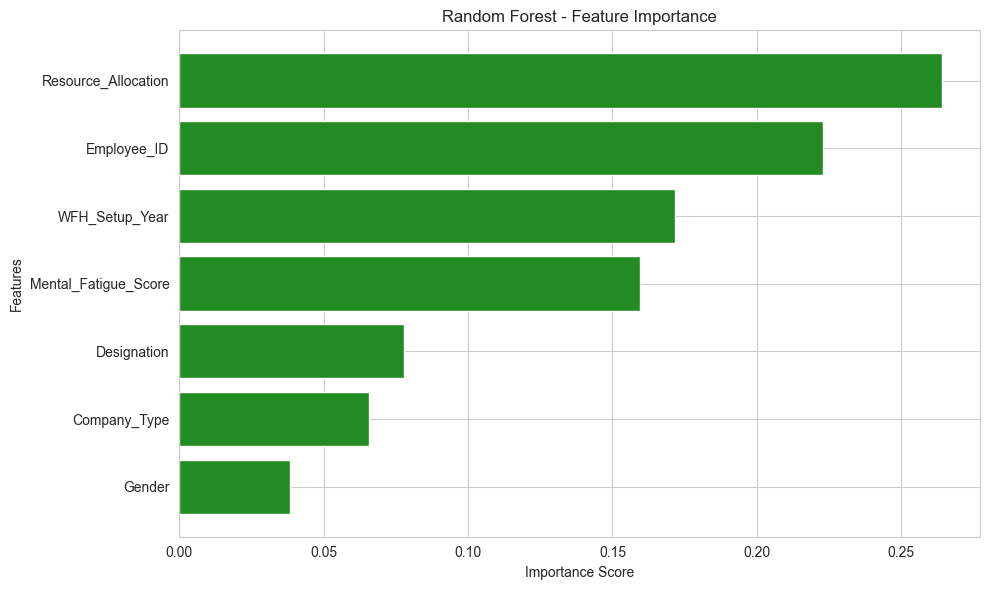


Top 5 most important features:
                Feature  Importance
5   Resource_Allocation    0.264072
0           Employee_ID    0.222768
2        WFH_Setup_Year    0.171802
6  Mental_Fatigue_Score    0.159548
4           Designation    0.077826


In [34]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

## 11. Visualizations

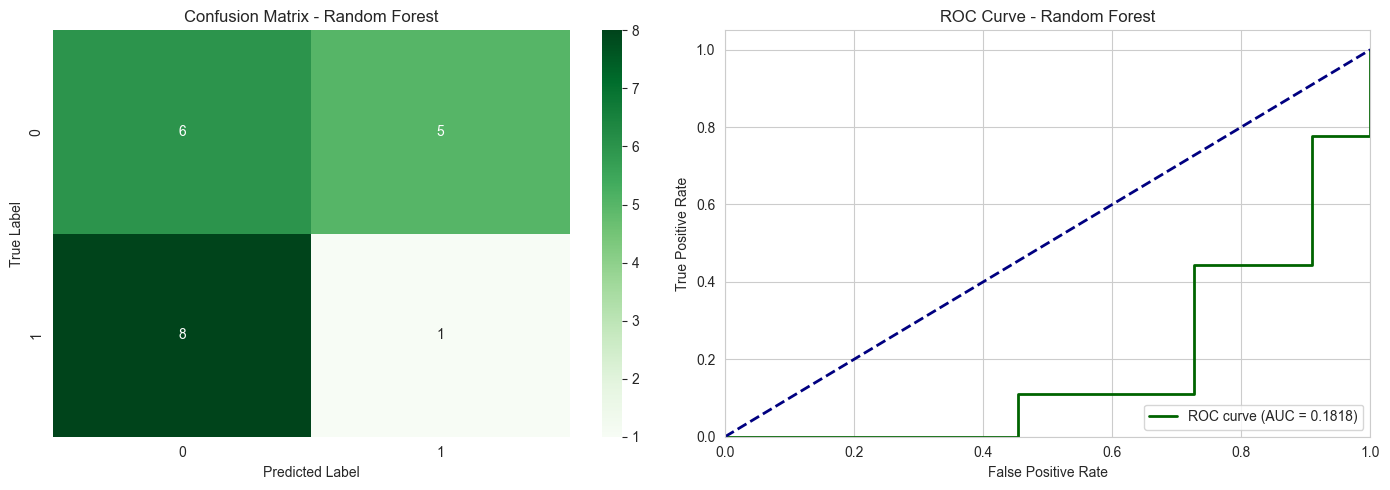


Visualizations complete!


In [35]:
# Plot Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Random Forest')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 12. Model Summary

In [36]:
print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Random Forest Ensemble")
print(f"Number of Trees: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nTop 3 Most Important Features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


RANDOM FOREST CLASSIFIER MODEL SUMMARY

Model Type: Random Forest Ensemble
Number of Trees: 100
Max Depth: 10
Training Samples: 80
Testing Samples: 20
Number of Features: 7

Key Metrics:
  - Accuracy:  0.3500
  - AUC Score: 0.1818
  - F1 Score:  0.3240

Top 3 Most Important Features:
  - Resource_Allocation: 0.2641
  - Employee_ID: 0.2228
  - WFH_Setup_Year: 0.1718

Model Status: ✅ Training Complete
